# Experiments

In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np
from torchvision import transforms
import torch
import clip
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from rich import print
# to_pil = transforms.ToPILImage()


def find_avg_centroid(x):
    return np.mean(x, axis=0)

# def find_avg_centroid(x):
#     length, dim = x.shape
#     return np.array([np.sum(x[:, i])/length for i in range(dim)])

def find_nearest_centroids(x, y):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()
        
    clf = NearestCentroid(metric='manhattan')
    clf = clf.fit(x, y)
    centroids = clf.centroids_
    return centroids

def find_knn(x, centroids, n_neighbors=10):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()

    knn_search = NearestNeighbors(n_neighbors=n_neighbors,
                            # metric='cosine', # because CLIP model
                            metric='manhattan', # because CLIP model
                            algorithm='auto', #'ball_tree'
                            n_jobs=-1)  
    knn_search.fit(x)

    indexes = knn_search.kneighbors(centroids, return_distance=False)
    return x[indexes][0]

        
def get_clusters(x):
    # X = mde_embedding
    # x = x.detach().cpu().numpy()
    # db = DBSCAN(eps=0.8, min_samples=10, n_jobs=-1, metric='manhattan').fit(X)
    # db = OPTICS(min_samples=2).fit(x)
    db = DBSCAN(eps=0.3, min_samples=10, leaf_size=30, 
                n_jobs=-1, metric='cosine').fit(x)

    # core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    # core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    if n_clusters_ == 0:
        return x, labels, n_clusters_
    # Remove outliers to avoid affecting the centroids
    x = x[np.where(labels != -1)]
    labels = labels[np.where(labels != -1)]
    
    return x, labels, n_clusters_


def get_nearest_embedding_centroids(x, n_neighbors=10):
    # print(task.task.title())
    # print(f"CLIP Embedding shape: {task.embeddings.shape}")
    
    #1. Get the CLIP embeddings
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()
    
    #3. Cluster the embeddings
    x, labels, n_clusters = get_clusters(x)

    #4. Find centroids of embeddings
    if n_clusters < 2:
        centroids = find_avg_centroid(x)
        centroids = centroids.reshape(1, -1)
    else:
        centroids = find_nearest_centroids(x, labels)

    # If some infinite/nan values appear
    centroids = np.nan_to_num(centroids)
    #5. Find knn of centroids        
    x_nearest_centroids = find_knn(x, centroids, n_neighbors)
    # x_nearest_centroids2 = np.vstack([find_knn(x, [centroid], n_neighbors) for centroid in centroids])
    # return centroids
    x_chosen = np.vstack([centroids, x_nearest_centroids])
    # x_chosen = np.vstack([centroids, x_nearest_centroids, x_nearest_centroids2])
    print(f"# nearest centroids ({round((x_chosen.shape[0]/x.shape[0])*100, 2)}%):", x_chosen.shape)
    print()

    return x_chosen


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
embeder, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, util
from functools import lru_cache

@lru_cache(maxsize=None)
def get_embeddings(dataset):
    
    all_features = []
    all_labels = []
    all_tasks = []
    
    with torch.no_grad():
        for images, labels, tasks in tqdm(DataLoader(dataset, batch_size=100, num_workers=8)):
            features = embeder.encode_image(images.to(device))
            # features = embeder_resnet(images.to(device)).squeeze()

            all_features.append(features)
            all_labels.append(labels)
            all_tasks.append(tasks)

    return (torch.cat(all_features).cpu().numpy(), 
            torch.cat(all_labels).cpu().numpy(), torch.cat(all_tasks).cpu().numpy())


In [4]:
import sys
sys.path.append('./CLAD/')

In [5]:
import clad
import torchvision

root = "./data"
original_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.3252, 0.3283, 0.3407), (0.0265, 0.0241, 0.0252))

])

# all_train_sets = clad.get_cladc_train(root, transform=lambda x: x)
all_train_sets = clad.get_cladc_train(root, transform=original_transform)
# val_sets = clad.get_cladc_val(root, transform=torchvision.transforms.ToTensor())
print(len(all_train_sets))
print([len(ts) for ts in all_train_sets])

[INFO] No Detectron installation found, continuing without.


6

[5157, 1154, 6742, 2560, 4517, 2119]

In [6]:
# method_transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.ToPILImage()
# ])
method_transform = torchvision.transforms.Compose([
    preprocess
])
all_train_sets_method = clad.get_cladc_train(root, transform=method_transform)
print(len(all_train_sets_method))
print([len(ts) for ts in all_train_sets_method])

6

[5157, 1154, 6742, 2560, 4517, 2119]

In [7]:
import torch
from torch.utils.data import random_split

# Define the split sizes for each dataset
train_size = 0.8
# test_size = 0.2

# Split each dataset in the train_sets list into training and testing sets
train_sets = []
test_sets = []
for dataset in all_train_sets:
    dataset_size = len(dataset)
    train_dataset_size = int(train_size * dataset_size)
    test_dataset_size = dataset_size - train_dataset_size
    train_dataset, test_dataset = random_split(dataset, [train_dataset_size, test_dataset_size], 
                                               generator=torch.Generator().manual_seed(42))
    train_sets.append(train_dataset)
    test_sets.append(test_dataset)

print("Original data")
print('Training lenghts: ', [len(ts) for ts in train_sets])
print('Testing lenghts: ', [len(ts) for ts in test_sets])

train_sets_method = []
test_sets_method = []
for dataset in all_train_sets_method:
    dataset_size = len(dataset)
    train_dataset_size = int(train_size * dataset_size)
    test_dataset_size = dataset_size - train_dataset_size
    train_dataset, test_dataset = random_split(dataset, [train_dataset_size, test_dataset_size], 
                                               generator=torch.Generator().manual_seed(42))
    train_sets_method.append(train_dataset)
    test_sets_method.append(test_dataset)

print("Method data")
print('Training lenghts: ', [len(ts) for ts in train_sets_method])
print('Testing lenghts: ', [len(ts) for ts in test_sets_method])

Original data

Training lenghts: 
[4125, 923, 5393, 2048, 3613, 1695]

Testing lenghts: 
[1032, 231, 1349, 512, 904, 424]

Method data

Training lenghts: 
[4125, 923, 5393, 2048, 3613, 1695]

Testing lenghts: 
[1032, 231, 1349, 512, 904, 424]

In [8]:
%%time
from torch.utils.data.dataset import TensorDataset
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.utils import make_classification_dataset
from torch.utils.data import DataLoader
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark



# Original benchmark with tasks
training_datasets = list()
testing_datasets = list()

for task, (train_s, test_s) in enumerate(zip(train_sets, test_sets), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(task, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(task, len(test_s))))

benchmark= dataset_benchmark(
    training_datasets,
    testing_datasets
)

# Original benchmark without tasks
training_datasets = list()
testing_datasets = list()
for task, (train_s, test_s) in enumerate(zip(train_sets, test_sets), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(0, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(0, len(test_s))))

benchmark_no_task= dataset_benchmark(
    training_datasets,
    testing_datasets
)

# Method benchmark
training_datasets = list()
testing_datasets = list()
for task, (train_s, test_s) in enumerate(zip(train_sets_method, test_sets_method), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(task, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(task, len(test_s))))

benchmark_method= dataset_benchmark(
    training_datasets,
    testing_datasets
)

CPU times: user 511 ms, sys: 145 ms, total: 656 ms
Wall time: 731 ms


## Test classifier

In [9]:
train_stream = benchmark_method.train_stream
test_stream = benchmark_method.test_stream

all_x_train_emb = list()
all_y_train = list()
all_t_train = list()

all_x_test_emb = list()
all_y_test = list()
all_t_test = list()


for task, experience in enumerate(train_stream):
    print("Getting embeddings")
    x_train_emb, y_train, t_train = get_embeddings(train_stream[task].dataset)

    print("x_train shape: ", x_train_emb.shape)
    all_x_train_emb.append(x_train_emb)
    all_y_train.append(y_train)
    all_t_train.append(t_train)

    x_test_emb, y_test, t_test = get_embeddings(test_stream[task].dataset)
    print("x_test shape: ", x_test_emb.shape)
    all_x_test_emb.append(x_test_emb)
    all_y_test.append(y_test)
    all_t_test.append(t_test)

Getting embeddings

100%|██████████| 42/42 [00:34<00:00,  1.21it/s]


x_train shape: 
(4125, 512)

100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


x_test shape: 
(1032, 512)

Getting embeddings

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


x_train shape: 
(923, 512)

100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


x_test shape: 
(231, 512)

Getting embeddings

100%|██████████| 54/54 [00:55<00:00,  1.02s/it]


x_train shape: 
(5393, 512)

100%|██████████| 14/14 [00:14<00:00,  1.06s/it]


x_test shape: 
(1349, 512)

Getting embeddings

100%|██████████| 21/21 [00:20<00:00,  1.05it/s]


x_train shape: 
(2048, 512)

100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


x_test shape: 
(512, 512)

Getting embeddings

100%|██████████| 37/37 [00:34<00:00,  1.07it/s]


x_train shape: 
(3613, 512)

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


x_test shape: 
(904, 512)

Getting embeddings

100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


x_train shape: 
(1695, 512)

100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


x_test shape: 
(424, 512)

In [10]:
%%time
print("Training data knn")
x_train_knn_total = [get_nearest_embedding_centroids(task, n_neighbors=10) for task in all_x_train_emb]
print("x_train_knn shape: ", [e.shape[0] for e in x_train_knn_total])
y_train_knn_total = [all_t_train[i][:x_train_knn_total[i].shape[0]] for i in range(len(all_t_train))]
x_train_knn_total = np.vstack(x_train_knn_total)
y_train_knn_total = np.hstack(y_train_knn_total)
print(x_train_knn_total.shape)
print("y_train_knn_total ", y_train_knn_total.shape)

print()
print("Testing")
print("x_test shape: ", [e.shape[0] for e in all_x_test_emb])
x_test_total = np.vstack(all_x_test_emb)
y_test_total = np.hstack(all_t_test)
print("x_test_total ", x_test_total.shape)
print("y_test_total ", y_test_total.shape)

Training data knn

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.19%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.2%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.54%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.3%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.65%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11]

(66, 512)

y_train_knn_total 
(66,)

Testing

x_test shape: 
[1032, 231, 1349, 512, 904, 424]

x_test_total 
(4452, 512)

y_test_total 
(4452,)

CPU times: user 58 s, sys: 1min 21s, total: 2min 19s
Wall time: 2.83 s


In [15]:
# from sklearn.neighbors import NearestCentroid
# from sklearn.preprocessing import StandardScaler

# def scale_data(x_train, x_test):
#     scaler = StandardScaler()
#     scaler.fit(x_train)
#     x_train_scaled = scaler.transform(x_train)
#     x_test_scaled = scaler.transform(x_test)
#     return x_train_scaled, x_test_scaled

# x_train_scaled, x_test_scaled = scale_data(x_train_knn_total, x_test_total)

clf = NearestCentroid(metric='manhattan')
clf = clf.fit(x_train_knn_total, y_train_knn_total)
print(f"score training knn: {clf.score(x_train_knn_total, y_train_knn_total)}")
print(f"score testing: {clf.score(x_test_total, y_test_total)}")
# clf = clf.fit(x_train_scaled, y_train_knn_total)
# print(f"score training knn: {clf.score(x_train_scaled, y_train_knn_total)}")
# print(f"score testing: {clf.score(x_test_scaled, y_test_total)}")


score training knn: 1.0

score testing: 0.5119047619047619

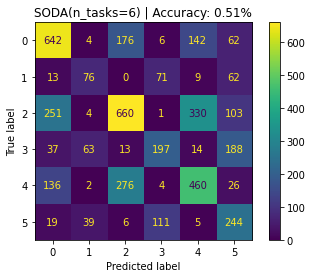

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
# plot_confusion_matrix(clf, x_val_total, y_val_total)  
predictions = clf.predict(x_test_total)
cm = confusion_matrix(y_test_total, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)

disp.plot()
plt.title(f"SODA(n_tasks=6) | Accuracy: {round(clf.score(x_test_total, y_test_total), 2)}%")
plt.show();

## Training

In [17]:
import statistics as st


def run_method(benchmark_method, test_stream, new_training, new_testing, task=0):
    print("Getting embeddings")
    x_train_emb, y_train, t_train = get_embeddings(benchmark_method.train_stream[task].dataset)


    print("x_train shape: ", x_train_emb.shape)
    all_x_train_emb.append(x_train_emb)
    all_y_train.append(y_train)
    all_t_train.append(t_train)

    # Training incremental domain classifier
    print("Training Domain Classifier model")
    x_train_knn_total = [get_nearest_embedding_centroids(_x_train, n_neighbors=10) for _x_train in all_x_train_emb]
    print("x_train_knn shape: ", [e.shape[0] for e in x_train_knn_total])
    y_train_knn_total = [all_t_train[i][:x_train_knn_total[i].shape[0]] for i in range(len(all_t_train))]
    x_train_knn_total = np.vstack(x_train_knn_total)
    y_train_knn_total = np.hstack(y_train_knn_total)
    print("x_train_knn_total shape: ", x_train_knn_total.shape)
    print("y_train_knn_total shape", y_train_knn_total.shape)
    if len(set(y_train_knn_total)) > 1:
        clf = NearestCentroid(metric='manhattan')
        clf = clf.fit(x_train_knn_total, y_train_knn_total)
        
    print("y_train_knn_total", np.random.choice(y_train_knn_total, 10))
    
    # Testing
    # print("Testing")
    x_test_emb, y_test, t_test = get_embeddings(benchmark_method.test_stream[task].dataset)

    if len(set(y_train_knn_total)) > 1:
        print("Using the classifier:")
        task_labels = clf.predict(x_test_emb)
        print("Count predictions: ", dict(zip(*np.unique(task_labels, return_counts=True))))
        print("Using the mode to get the most voting prediction:")
        mode = st.mode(task_labels)
        task_labels = np.repeat(mode, len(task_labels))
    else:
        print("Fist scenario: Task ID=", task)
        task_labels = np.repeat(task, len(benchmark_method.test_stream[task].dataset))
    print(f"Predictions: {np.random.choice(task_labels, 10)}")
    print(f"Predictions shape: {task_labels.shape}")

    new_training.append(benchmark_method.train_stream[task].dataset)
    new_testing.append(make_classification_dataset(test_stream[task].dataset, task_labels=task_labels))

    benchmark_custom = dataset_benchmark(
        new_training,
        new_testing
    )

    return benchmark_custom

In [102]:
import torch
import random
import gc
from torch.nn import CrossEntropyLoss
import copy
import statistics as st
from torch.optim import Adam
from rich import print
from avalanche.models import as_multitask
from avalanche.benchmarks.classic import SplitMNIST, PermutedMNIST
from avalanche.models import MTSimpleMLP, MTSimpleCNN, SimpleCNN, SimpleMLP
# from avalanche.training.supervised import EWC, Naive, LFL
from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
)
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
# from avalanche.training import Naive
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from avalanche.benchmarks.classic import SplitMNIST, PermutedMNIST, RotatedMNIST, SplitCIFAR10, SplitCIFAR100
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark
from avalanche.training.utils import adapt_classification_layer

from datetime import datetime
from avalanche.evaluation.metrics.images_samples import images_samples_metrics
from avalanche.evaluation.metrics.labels_repartition import (
    labels_repartition_metrics,
)
from avalanche.evaluation.metrics.mean_scores import mean_scores_metrics
from torch.nn import Linear
from avalanche.training.supervised import Replay, GEM, LwF, EWC


num_experiments = 2
# num_experiments = 3
random_seeds = [42, 123, 456]

# results_list = []
for exp in range(1, num_experiments):
    
    train_stream = benchmark.train_stream
    test_stream = benchmark.test_stream

    print(f"Length training: {len(benchmark.train_stream[0].dataset)}")
    print(f"Length testing: {len(benchmark.test_stream[0].dataset)}")

    print("-"*50)

    all_x_train_emb = list()
    all_y_train = list()
    all_t_train = list()

    all_x_test_emb = list()
    all_y_test = list()
    all_t_test = list()


    model = torchvision.models.resnet18(weights=True)
    # model.fc = Linear(model.fc.in_features, 7, bias=True)
    model.fc = Linear(model.fc.in_features, 7, bias=True)
    mt_model = as_multitask(model, 'fc')

    optimizer = Adam(mt_model.parameters(), lr=0.01)
    criterion = CrossEntropyLoss()

    # choose some metrics and evaluation method
    loggers = []

    loggers.append(InteractiveLogger())

    eval_plugin = EvaluationPlugin(
        accuracy_metrics(
            minibatch=False, epoch=True, experience=True
        ),

        forgetting_metrics(experience=True),
        loggers=loggers,
    )

    strategies = {
        'EWC': EWC( #Regularization-based method
            model=mt_model,
            optimizer=optimizer,
            criterion=criterion,
            train_mb_size=200,
            train_epochs=4,
            eval_mb_size=200,
            device=device,
            evaluator=eval_plugin,
            ewc_lambda=0.2,
        ),
        'Replay': Replay( #Rehearsal-based method
            model=mt_model,
            optimizer=optimizer,
            criterion=criterion,
            train_mb_size=200,
            train_epochs=4,
            eval_mb_size=200,
            device=device,
            evaluator=eval_plugin,
            mem_size=2000,
        ),
        'LwF': LwF( #Architecture-based method
            mt_model,
            optimizer,
            criterion,
            alpha=0.5,
            temperature=0.2,
            train_epochs=4,
            device=device,
            train_mb_size=200,
            eval_mb_size=200,
            evaluator=eval_plugin,
        ),
    }

    n_workers = 8



    seed = random_seeds[exp]
    random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    
    for strategy_name in strategies:
#         model = torchvision.models.resnet18(weights=True)
#         model.fc = Linear(model.fc.in_features, 7, bias=True)
#         mt_model = as_multitask(model, 'fc')

#         optimizer = Adam(mt_model.parameters(), lr=0.01)
#         criterion = CrossEntropyLoss()
    
        strategy = strategies[strategy_name]
        print(f"Running strategy: {strategy}, experiment: {exp}")
        results = {key: [] for key in ['ground_truth', 'TADIL', 'normal']}
        
        new_training = list()
        new_testing = list()

        for task, experience in enumerate(train_stream):
            curr_experience = experience.current_experience
            print("Current experience: ", curr_experience)    
            print("Experience task ID ", experience.task_label)
            print('Experience shape:', len(experience.dataset))


            # Training
            print("Training experience")
            strategy.train(experience, num_workers=n_workers)

            print('Training completed')

            # Run the method
            # benchmark_custom = run_method(benchmark_method, test_stream, task=task)
            benchmark_custom = run_method(benchmark_method, test_stream, new_training, new_testing, task=0)

            # Testing
            print("Evaluation benchmark: Ground Truth")
            results['ground_truth'].append(strategy.eval(benchmark.test_stream[:task+1], num_workers=n_workers))

            print("Evaluation benchmark: TADIL")
            results['TADIL'].append(strategy.eval(benchmark_custom.test_stream, num_workers=n_workers))

            print("Evaluation benchmark: Normal")
            results['normal'].append(strategy.eval(benchmark_no_task.test_stream[:task+1], num_workers=n_workers))

            print("-"*40)
            print()

        
        benchmark_custom = None
        
        with open(f'{strategy_name}_{exp}.pickle', 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print(f"Saved results for {strategy_name}, exp: {exp}:")

        print("-"*40)
        print()
    print("-"*80)

Length training: 4125

Length testing: 1032

--------------------------------------------------

/opt/intel/oneapi/intelpython/latest/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Running strategy: <avalanche.training.supervised.strategy_wrappers.EWC object at 0x7f3722164760>, experiment: 1

Current experience:  0

Experience task ID  0

Experience shape: 4125

Training experience

-- >> Start of training phase << --
100%|██████████| 21/21 [00:18<00:00,  1.13it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4618
100%|██████████| 21/21 [00:18<00:00,  1.16it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4790
100%|██████████| 21/21 [00:18<00:00,  1.15it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5384
100%|██████████| 21/21 [00:19<00:00,  1.07it/s]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6128
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11]

x_train_knn_total shape: 
(11, 512)

y_train_knn_total shape
(11,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6027
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6027
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6027
-- >> End of eval phase << --


----------------------------------------

Current experience:  1

Experience task ID  1

Experience shape: 923

Training experience

-- >> Start of training phase << --
100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.4800
100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.7974
100%|██████████| 5/5 [00:08<00:00,  1.70s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.8819
100%|██████████| 5/5 [00:08<00:00,  1.69s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.8754
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11]

x_train_knn_total shape: 
(22, 512)

y_train_knn_total shape
(22,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0979
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5048
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.90s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.6970
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0979
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5048
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.5048
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0979
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5048
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.95s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.6494
-- >> End of eval phase << --


----------------------------------------

Current experience:  2

Experience task ID  2

Experience shape: 5393

Training experience

-- >> Start of training phase << --
100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.5880
100%|██████████| 27/27 [00:25<00:00,  1.08it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.6822
100%|██████████| 27/27 [00:24<00:00,  1.10it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.7424
100%|██████████| 27/27 [00:24<00:00,  1.09it/s]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.7832
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11]

x_train_knn_total shape: 
(33, 512)

y_train_knn_total shape
(33,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:08<00:00,  1.42s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = -0.0426
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6453
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.40s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = -0.1169
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.7662
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.7680
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:07<00:00,  1.21s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = -0.0426
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6453
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:07<00:00,  1.19s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0040
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.6453
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.15s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.6453
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:08<00:00,  1.37s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = -0.0426
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6453
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.44s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = -0.0563
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7056
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.11s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.5115
-- >> End of eval phase << --


----------------------------------------

Current experience:  3

Experience task ID  3

Experience shape: 2048

Training experience

-- >> Start of training phase << --
100%|██████████| 11/11 [00:17<00:00,  1.59s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.7900
100%|██████████| 11/11 [00:15<00:00,  1.42s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.8872
100%|██████████| 11/11 [00:15<00:00,  1.36s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.9048
100%|██████████| 11/11 [00:14<00:00,  1.29s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.9214
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11]

x_train_knn_total shape: 
(44, 512)

y_train_knn_total shape
(44,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.16s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0048
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5979
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.15s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = -0.2597
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.9091
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:08<00:00,  1.24s/it]
> Eval on experience 2 (Task 2) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task002/Exp002 = -0.1053
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.6168
-- Starting eval on experience 3 (Task 3) from test stream --
100%|██████████| 3/3 [

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:07<00:00,  1.26s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0048
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5979
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.15s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0515
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.5979
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.13s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.0864
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.5979
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 6/6 [0

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0048
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5979
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.94s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = -0.0649
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7143
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.0771
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.5886
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 3/3 [

----------------------------------------

Current experience:  4

Experience task ID  4

Experience shape: 3613

Training experience

-- >> Start of training phase << --
100%|██████████| 19/19 [00:17<00:00,  1.07it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.7066
100%|██████████| 19/19 [00:19<00:00,  1.01s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.7598
100%|██████████| 19/19 [00:18<00:00,  1.01it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.7861
100%|██████████| 19/19 [00:18<00:00,  1.02it/s]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.8054
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11]

x_train_knn_total shape: 
(55, 512)

y_train_knn_total shape
(55,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = -0.0107
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6134
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.06s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = -0.1818
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8312
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task002/Exp002 = -0.2394
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.7509
-- Starting eval on experience 3 (Task 3) from test stream --
100%|██████████| 3/3 

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = -0.0107
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6134
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.11s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0360
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.6134
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.1019
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.6134
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 6/6 [

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.12s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = -0.0107
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6134
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.03s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = -0.0606
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7100
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.0852
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.5967
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 3/3 

----------------------------------------

Current experience:  5

Experience task ID  5

Experience shape: 1695

Training experience

-- >> Start of training phase << --
100%|██████████| 9/9 [00:11<00:00,  1.29s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.5735
100%|██████████| 9/9 [00:11<00:00,  1.25s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.6914
100%|██████████| 9/9 [00:11<00:00,  1.23s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.7363
100%|██████████| 9/9 [00:11<00:00,  1.23s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.7829
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(66, 512)

y_train_knn_total shape
(66,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0184
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5843
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.90s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = -0.2468
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8961
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task002/Exp002 = -0.1016
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.6130
-- Starting eval on experience 3 (Task 3) from test stream --
100%|██████████| 3/3 [

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0184
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5843
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0650
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.5843
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.0728
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.5843
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 6/6 [0

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0184
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5843
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.96s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = -0.0087
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.6580
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.02s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.0126
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.5241
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 3/3 [

----------------------------------------

Saved results for EWC, exp: 1:

----------------------------------------

Running strategy: <avalanche.training.supervised.strategy_wrappers.Replay object at 0x7f36fcfd6880>, experiment: 1

Current experience:  0

Experience task ID  0

Experience shape: 4125

Training experience

-- >> Start of training phase << --
100%|██████████| 21/21 [00:17<00:00,  1.18it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7115
100%|██████████| 21/21 [00:18<00:00,  1.16it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7806
100%|██████████| 21/21 [00:18<00:00,  1.13it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8187
100%|██████████| 21/21 [00:18<00:00,  1.15it/s]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8381
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(77, 512)

y_train_knn_total shape
(77,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8178
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8178
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8178
-- >> End of eval phase << --


----------------------------------------

Current experience:  1

Experience task ID  1

Experience shape: 923

Training experience

-- >> Start of training phase << --
100%|██████████| 10/10 [00:21<00:00,  2.17s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.8713
100%|██████████| 10/10 [00:21<00:00,  2.11s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.8833
100%|██████████| 10/10 [00:21<00:00,  2.17s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.9126
100%|██████████| 10/10 [00:21<00:00,  2.14s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.9373
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(88, 512)

y_train_knn_total shape
(88,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0107
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8072
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.90s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.9437
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0107
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8072
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8072
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0107
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8072
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.91s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9221
-- >> End of eval phase << --


----------------------------------------

Current experience:  2

Experience task ID  2

Experience shape: 5393

Training experience

-- >> Start of training phase << --
100%|██████████| 27/27 [00:46<00:00,  1.74s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.8606
100%|██████████| 27/27 [00:46<00:00,  1.71s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.9004
100%|██████████| 27/27 [00:47<00:00,  1.76s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.9256
100%|██████████| 27/27 [00:47<00:00,  1.76s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.9496
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(99, 512)

y_train_knn_total shape
(99,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.12s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0058
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8120
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.98s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = 0.0303
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.8918
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.02s/it]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.8347
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0058
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8120
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.1101
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8120
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.8120
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0058
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8120
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.94s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0823
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8398
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.8043
-- >> End of eval phase << --


----------------------------------------

Current experience:  3

Experience task ID  3

Experience shape: 2048

Training experience

-- >> Start of training phase << --
100%|██████████| 11/11 [00:29<00:00,  2.65s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.9197
100%|██████████| 11/11 [00:28<00:00,  2.58s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.9433
100%|██████████| 11/11 [00:27<00:00,  2.54s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.9430
100%|██████████| 11/11 [00:27<00:00,  2.48s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.9122
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(110, 512)

y_train_knn_total shape
(110,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0833
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7345
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.91s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = 0.0130
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.9091
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task002/Exp002 = 0.0801
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.7242
-- Starting eval on experience 3 (Task 3) from test stream --
100%|██████████| 3/3 [00

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0833
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7345
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.1876
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7345
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.06s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = 0.0698
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.7345
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 6/6 [00

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.11s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0833
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7345
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.97s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.1948
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7273
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = 0.0608
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.7435
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 3/3 [00

----------------------------------------

Current experience:  4

Experience task ID  4

Experience shape: 3613

Training experience

-- >> Start of training phase << --
100%|██████████| 19/19 [00:35<00:00,  1.87s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.8678
100%|██████████| 19/19 [00:33<00:00,  1.76s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.9056
100%|██████████| 19/19 [00:33<00:00,  1.78s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.9197
100%|██████████| 19/19 [00:33<00:00,  1.79s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.9145
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(121, 512)

y_train_knn_total shape
(121,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.14s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0388
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7791
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.08s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = 0.0173
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.9048
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.02s/it]
> Eval on experience 2 (Task 2) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task002/Exp002 = 0.0208
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.7835
-- Starting eval on experience 3 (Task 3) from test stream --
100%|██████████| 3/3 [00

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0388
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7791
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.1430
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7791
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.11s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = 0.0252
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.7791
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 6/6 [00

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0388
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7791
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.07s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0346
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8874
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.0007
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.8050
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 3/3 [0

----------------------------------------

Current experience:  5

Experience task ID  5

Experience shape: 1695

Training experience

-- >> Start of training phase << --
100%|██████████| 10/10 [00:27<00:00,  2.71s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.8511
100%|██████████| 10/10 [00:25<00:00,  2.55s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.9068
100%|██████████| 10/10 [00:26<00:00,  2.62s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.9440
100%|██████████| 10/10 [00:26<00:00,  2.65s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.9623
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(132, 512)

y_train_knn_total shape
(132,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0397
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7781
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.98s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = -0.0216
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.9437
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.02s/it]
> Eval on experience 2 (Task 2) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task002/Exp002 = -0.0089
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.8132
-- Starting eval on experience 3 (Task 3) from test stream --
100%|██████████| 3/3 [

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0397
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7781
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.1440
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7781
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = 0.0262
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.7781
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 6/6 [00

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0397
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7781
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.02s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0433
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8788
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.02s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = 0.0274
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.7769
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 3/3 [00

----------------------------------------

Saved results for Replay, exp: 1:

----------------------------------------

Running strategy: <avalanche.training.supervised.strategy_wrappers.LwF object at 0x7f37221243a0>, experiment: 1

Current experience:  0

Experience task ID  0

Experience shape: 4125

Training experience

-- >> Start of training phase << --
100%|██████████| 21/21 [00:18<00:00,  1.15it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8400
100%|██████████| 21/21 [00:17<00:00,  1.20it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9030
100%|██████████| 21/21 [00:17<00:00,  1.17it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9408
100%|██████████| 21/21 [00:17<00:00,  1.17it/s]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9598
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(143, 512)

y_train_knn_total shape
(143,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.11s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8731
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8731
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8731
-- >> End of eval phase << --


----------------------------------------

Current experience:  1

Experience task ID  1

Experience shape: 923

Training experience

-- >> Start of training phase << --
100%|██████████| 5/5 [00:10<00:00,  2.13s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.9415
100%|██████████| 5/5 [00:10<00:00,  2.02s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.9653
100%|██████████| 5/5 [00:10<00:00,  2.09s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.9642
100%|██████████| 5/5 [00:10<00:00,  2.02s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task001 = 0.9653
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(154, 512)

y_train_knn_total shape
(154,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0940
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7791
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.00s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.9351
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.11s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0940
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7791
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7791
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0940
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7791
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.99s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8571
-- >> End of eval phase << --


----------------------------------------

Current experience:  2

Experience task ID  2

Experience shape: 5393

Training experience

-- >> Start of training phase << --
100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.8494
100%|██████████| 27/27 [00:27<00:00,  1.03s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.8889
100%|██████████| 27/27 [00:27<00:00,  1.03s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.9184
100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task002 = 0.9397
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(165, 512)

y_train_knn_total shape
(165,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.1134
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7597
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.94s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = -0.0693
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.9264
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.8732
-- >> End of eval phase << --


Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.1134
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7597
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.06s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0975
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7597
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.7597
-- >> End of eval phase << --


Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.1134
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7597
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.93s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0260
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8312
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.6783
-- >> End of eval phase << --


----------------------------------------

Current experience:  3

Experience task ID  3

Experience shape: 2048

Training experience

-- >> Start of training phase << --
100%|██████████| 11/11 [00:13<00:00,  1.23s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.9214
100%|██████████| 11/11 [00:13<00:00,  1.23s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.9243
100%|██████████| 11/11 [00:13<00:00,  1.23s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.9399
100%|██████████| 11/11 [00:14<00:00,  1.29s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task003 = 0.9399
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(176, 512)

y_train_knn_total shape
(176,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.1124
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7607
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.01s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = -0.0693
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.9264
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.02s/it]
> Eval on experience 2 (Task 2) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task002/Exp002 = -0.1557
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.8340
-- Starting eval on experience 3 (Task 3) from test stream --
100%|██████████| 3/3 [

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.1124
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7607
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0965
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7607
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.0824
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.7607
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 6/6 [0

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.1124
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7607
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.03s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0087
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.8485
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.0022
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.6805
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 3/3 [0

----------------------------------------

Current experience:  4

Experience task ID  4

Experience shape: 3613

Training experience

-- >> Start of training phase << --
100%|██████████| 19/19 [00:19<00:00,  1.03s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.8478
100%|██████████| 19/19 [00:20<00:00,  1.07s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.8724
100%|██████████| 19/19 [00:20<00:00,  1.09s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.8489
100%|██████████| 19/19 [00:19<00:00,  1.02s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task004 = 0.8353
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(187, 512)

y_train_knn_total shape
(187,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.1822
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6909
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.95s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = -0.0649
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.9221
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
> Eval on experience 2 (Task 2) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task002/Exp002 = -0.1416
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.8199
-- Starting eval on experience 3 (Task 3) from test stream --
100%|██████████| 3/3 [

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.12s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.1822
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6909
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.13s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.1663
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.6909
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.12s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.0126
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.6909
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 6/6 [0

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.1822
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6909
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:06<00:00,  3.02s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.1558
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7013
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.02s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = 0.0378
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.6405
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 3/3 [00

----------------------------------------

Current experience:  5

Experience task ID  5

Experience shape: 1695

Training experience

-- >> Start of training phase << --
100%|██████████| 9/9 [00:12<00:00,  1.41s/it]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.6714
100%|██████████| 9/9 [00:12<00:00,  1.37s/it]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.7463
100%|██████████| 9/9 [00:12<00:00,  1.42s/it]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.7882
100%|██████████| 9/9 [00:11<00:00,  1.33s/it]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task005 = 0.8071
-- >> End of training phase << --


Training completed

Getting embeddings

x_train shape: 
(4125, 512)

Training Domain Classifier model

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.27%):
(11, 512)

x_train_knn shape: 
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

x_train_knn_total shape: 
(198, 512)

y_train_knn_total shape
(198,)

y_train_knn_total [0 0 0 0 0 0 0 0 0 0]

Fist scenario: Task ID= 0

Predictions: [0 0 0 0 0 0 0 0 0 0]

Predictions shape: (1032,)

Evaluation benchmark: Ground Truth

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0950
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7781
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.96s/it]
> Eval on experience 1 (Task 1) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task001/Exp001 = -0.0563
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.9134
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.02s/it]
> Eval on experience 2 (Task 2) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task002/Exp002 = -0.0875
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.7658
-- Starting eval on experience 3 (Task 3) from test stream --
100%|██████████| 3/3 [

Evaluation benchmark: TADIL

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0950
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7781
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = 0.0790
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.7781
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.0998
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.7781
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 6/6 [0

Evaluation benchmark: Normal

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp000 = 0.0950
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7781
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 2/2 [00:05<00:00,  2.93s/it]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp001 = -0.0476
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.9048
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
> Eval on experience 2 (Task 0) from test stream ended.
	ExperienceForgetting/eval_phase/test_stream/Task000/Exp002 = -0.0200
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.6983
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 3/3 [

----------------------------------------

Saved results for LwF, exp: 1:

----------------------------------------

--------------------------------------------------------------------------------

## Accuracy

In [21]:
strategy_name = "EWC"
n_exp = 0
# strategy_name = "LwF"
with open(f'{strategy_name}_{n_exp}.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [23]:
results.keys()

dict_keys(['ground_truth', 'TADIL', 'normal'])

In [98]:
# import matplotlib.pyplot as plt

# # Extract the eval_phase values
# def get_eval_phase_values(data, keyword):
#     eval_values = []
#     for exp in data:
#         eval_values.append({k: v for k, v in exp.items() if ('eval_phase/test_stream' in k) and (keyword in k)})
#     return eval_values

# results_clean = {k:get_eval_phase_values(results[k], "Top1_Acc_Exp") for k in results.keys()}

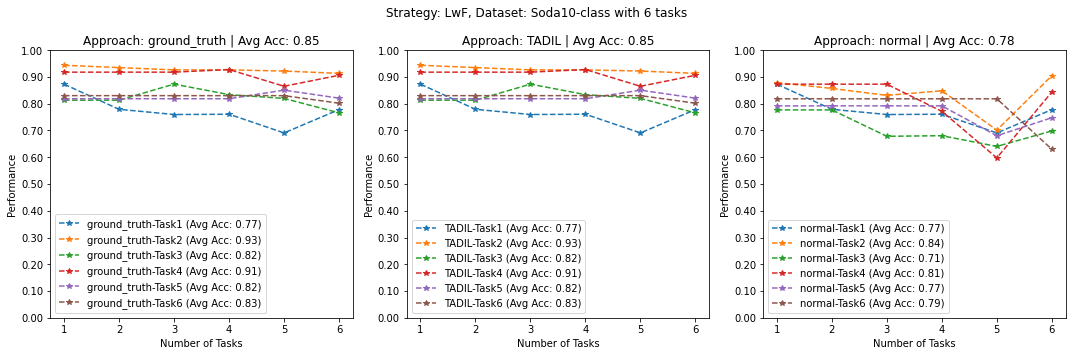

In [104]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

strategy_name = "LwF"
n_exp = 1
# strategy_name = "LwF"
with open(f'{strategy_name}_{n_exp}.pickle', 'rb') as handle:
    results = pickle.load(handle)


metric_root_name = "Top1_Acc_Exp/eval_phase/test_stream"

# Create a dictionary to store the scores for each method
method_scores = {
    'ground_truth': [],
    'TADIL': [],
    'normal': [],
}

for domain in range(len(results['ground_truth'])):
    scores_task = []
    scores_method = []
    scores_third_method = [] # Initialize an empty list for the scores of the third method
    iters_ = []
    for index, r in enumerate(results['ground_truth']):
        try:
            score_task = r[f"{metric_root_name}/Task00{domain}/Exp00{domain}"]
            score_method = results['TADIL'][index][f"{metric_root_name}/Task00{domain}/Exp00{domain}"]
            score_third_method = results['normal'][index][f"{metric_root_name}/Task00{0}/Exp00{domain}"] # Get the score of the third method
            if score_task != 0:
                scores_task.append(score_task)
                scores_method.append(score_method)
                scores_third_method.append(score_third_method) # Append the score of the third method to the list
                iters_.append(index + 1)
        except:
            pass
    method_scores['ground_truth'].append((iters_, scores_task))
    method_scores['TADIL'].append((iters_, scores_method))
    method_scores['normal'].append((iters_, scores_third_method)) # Append the scores of the third method to the dictionary


max_iter = max([max(scores, key=lambda s: s[0][-1])[0][-1] for scores in method_scores.values()])  # Get the maximum iteration index for all methods

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Create 3 subplots arranged horizontally
plt.suptitle(f"Strategy: {strategy_name}, Dataset: Soda10-class with {len(results['ground_truth'])} tasks")

for i, (method_name, method_scores_list) in enumerate(method_scores.items()):
    
    avg_list = list()
    for j, (x, y) in enumerate(method_scores_list):
        average_accuracy = np.mean(y)  # Calculate the average accuracy
        avg_list.append(average_accuracy)
        axs[i].plot(x, y, '*--', label=f'{method_name}-Task{j+1} (Avg Acc: {average_accuracy:.2f})')  # Include the average accuracy in the label
        axs[i].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i].set_yticklabels(["{:.2f}".format(val) for val in np.arange(0, 1.1, 0.1)])
        axs[i].legend()
        
    axs[i].set_title(f"Approach: {method_name} | Avg Acc: {round(np.mean(avg_list), 2)}")
    
    axs[i].set_xlabel("Number of Tasks")
    axs[i].set_ylabel("Performance")
    axs[i].set_xticks(np.arange(1, max_iter+1))

plt.tight_layout() 
# plt.savefig(f'{strategy_name}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


## Table

In [89]:
import pandas as pd

df_tables = dict()
strategy_names = ['EWC', 'LwF', 'Replay']
for strategy_name in strategy_names:
    # strategy_name = "LwF"
    n_exp = 1
    # strategy_name = "LwF"
    with open(f'{strategy_name}_{n_exp}.pickle', 'rb') as handle:
        results = pickle.load(handle)

    method_scores = {
        'ground_truth': [],
        'TADIL': [],
        'normal': [],
    }

    for domain in range(len(results['ground_truth'])):
        scores_task = []
        scores_method = []
        scores_third_method = []
        iters_ = []
        for index, r in enumerate(results['ground_truth']):
            try:
                score_task = r[f"{metric_root_name}/Task00{domain}/Exp00{domain}"]
                score_method = results['TADIL'][index][f"{metric_root_name}/Task00{domain}/Exp00{domain}"]
                score_third_method = results['normal'][index][f"{metric_root_name}/Task00{0}/Exp00{domain}"] # Get the score of the third method
                if score_task != 0:
                    scores_task.append(score_task)
                    scores_method.append(score_method)
                    scores_third_method.append(score_third_method) # Append the score of the third method to the list
                    iters_.append(index + 1)
            except:
                pass
        method_scores['ground_truth'].append((iters_, scores_task))
        method_scores['TADIL'].append((iters_, scores_method))
        method_scores['normal'].append((iters_, scores_third_method)) # Append the scores of the third method to the dictionary


    max_iter = max([max(scores, key=lambda s: s[0][-1])[0][-1] for scores in method_scores.values()])  # Get the maximum iteration index for all methods

    avg_acc_df = pd.DataFrame(columns=method_scores.keys(), index=range(1, len(method_scores_list) + 1))


    for method_name, method_scores_list in method_scores.items():
        for j, (x, y) in enumerate(method_scores_list):
            average_accuracy = np.mean(y)
            std_dev = np.std(y)
            avg_acc_df.at[j+1, method_name] = f"{average_accuracy:.2f} ({round(std_dev, 2)})"

    # Display the DataFrame
    avg_acc_df.index = [f"Task {i+1}" for i in range(len(method_scores_list))]
    avg_acc_df = avg_acc_df.reset_index()
    avg_acc_df = avg_acc_df.rename(columns={'index': 'Task ID', 'ground_truth': 'Ground Truth', 'normal': 'Normal'})
    print(strategy_name)
    print(avg_acc_df)
    df_tables[strategy_name] = avg_acc_df

EWC

Task ID Ground Truth        TADIL       Normal
0  Task 1  0.59 (0.03)  0.59 (0.03)  0.59 (0.03)
1  Task 2  0.85 (0.07)  0.85 (0.07)  0.84 (0.07)
2  Task 3  0.70 (0.06)  0.70 (0.06)  0.64 (0.03)
3  Task 4  0.89 (0.02)  0.89 (0.02)  0.87 (0.01)
4  Task 5  0.77 (0.03)  0.77 (0.03)  0.74 (0.04)
5  Task 6   0.76 (0.0)   0.76 (0.0)   0.56 (0.0)

LwF

Task ID Ground Truth        TADIL       Normal
0  Task 1  0.77 (0.05)  0.77 (0.05)  0.77 (0.05)
1  Task 2  0.92 (0.01)  0.92 (0.01)  0.88 (0.02)
2  Task 3  0.82 (0.02)  0.82 (0.02)  0.74 (0.03)
3  Task 4  0.91 (0.02)  0.91 (0.02)  0.83 (0.05)
4  Task 5   0.84 (0.0)   0.84 (0.0)  0.78 (0.03)
5  Task 6  0.84 (0.02)  0.84 (0.02)  0.77 (0.06)

Replay

Task ID Ground Truth        TADIL       Normal
0  Task 1  0.81 (0.01)  0.81 (0.01)  0.81 (0.01)
1  Task 2  0.92 (0.03)  0.92 (0.03)  0.89 (0.04)
2  Task 3  0.78 (0.08)  0.78 (0.08)   0.73 (0.1)
3  Task 4  0.90 (0.01)  0.90 (0.01)  0.87 (0.01)
4  Task 5  0.77 (0.05)  0.77 (0.05)  0.74 (0.04)
5  Task 6  0.77 (0.04)  0.77 (0.04)  0.60 (0.09)

In [93]:
import pandas as pd


final_df = pd.DataFrame()
for key, df in df_tables.items():

    df = df.reset_index(drop=True)
    df.insert(0, "Strategy", key)
    final_df = final_df.append(df, ignore_index=True)
    
unique_strategies = final_df["Strategy"].unique()
for i, strategy in enumerate(unique_strategies):
    final_df.loc[(final_df["Strategy"] == strategy) & (final_df.index != i * len(df)), "Strategy"] = ""


latex_table = final_df.to_latex(index=False, float_format="%.2f", bold_rows=True, column_format="|l|l|c|c|c|", multicolumn_format="c")


# Add grid lines to the table
latex_table = latex_table.replace('\\toprule', '\\hline')
latex_table = latex_table.replace('\\midrule', '\\hline')
latex_table = latex_table.replace('\\bottomrule', '\\hline')

# Print the LaTeX table
print(latex_table)


<ipython-input-93-948457822d61>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(df, ignore_index=True)
<ipython-input-93-948457822d61>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(df, ignore_index=True)
<ipython-input-93-948457822d61>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(df, ignore_index=True)
<ipython-input-93-948457822d61>:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

\begin{tabular}{|l|l|c|c|c|}
\hline
Strategy & Task ID & Ground Truth &       TADIL &      Normal \\
\hline
     EWC &  Task 1 &  0.59 (0.03) & 0.59 (0.03) & 0.59 (0.03) \\
         &  Task 2 &  0.85 (0.07) & 0.85 (0.07) & 0.84 (0.07) \\
         &  Task 3 &  0.70 (0.06) & 0.70 (0.06) & 0.64 (0.03) \\
         &  Task 4 &  0.89 (0.02) & 0.89 (0.02) & 0.87 (0.01) \\
         &  Task 5 &  0.77 (0.03) & 0.77 (0.03) & 0.74 (0.04) \\
         &  Task 6 &   0.76 (0.0) &  0.76 (0.0) &  0.56 (0.0) \\
     LwF &  Task 1 &  0.77 (0.05) & 0.77 (0.05) & 0.77 (0.05) \\
         &  Task 2 &  0.92 (0.01) & 0.92 (0.01) & 0.88 (0.02) \\
         &  Task 3 &  0.82 (0.02) & 0.82 (0.02) & 0.74 (0.03) \\
         &  Task 4 &  0.91 (0.02) & 0.91 (0.02) & 0.83 (0.05) \\
         &  Task 5 &   0.84 (0.0) &  0.84 (0.0) & 0.78 (0.03) \\
         &  Task 6 &  0.84 (0.02) & 0.84 (0.02) & 0.77 (0.06) \\
  Replay &  Task 1 &  0.81 (0.01) & 0.81 (0.01) & 0.81 (0.01) \\
         &  Task 2 &  0.92 (0.03) & 0.92 (0.03) & 0.89 (0.04) \\
         &  Task 3 &  0.78 (0.08) & 0.78 (0.08) &  0.73 (0.1) \\
         &  Task 4 &  0.90 (0.01) & 0.90 (0.01) & 0.87 (0.01) \\
         &  Task 5 &  0.77 (0.05) & 0.77 (0.05) & 0.74 (0.04) \\
         &  Task 6 &  0.77 (0.04) & 0.77 (0.04) & 0.60 (0.09) \\
\hline
\end{tabular}